In [58]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn geopandas shapely  textblob vaderSentiment  pmdarima

In [59]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
###. Step 1: Load the Refined Dataset

import pandas as pd

# Define the file path for the refined dataset
file_path = '/content/drive/MyDrive/refined_dataset.csv'

# Load the refined dataset
refined_dataset = pd.read_csv(file_path)

# Display the first few rows to verify the structure
print("Loaded Refined Dataset:")
display(refined_dataset.tail())

# Display the shape of the dataset
refined_dataset.shape


Loaded Refined Dataset:


,text,stars_y,review_count,useful,funny
18784,Nice Ramen Spot! I was travelling and craving ...,4,109,4,1
18785,Great Ramen.\nService was asking me to take my...,1,109,0,0
18786,"Great flavour to the Ramen dishes, and the ser...",5,109,0,0
18787,My husband and I do an instagram date on weeke...,4,109,0,0
18788,This place is impressively focused. They don't...,3,109,2,0


(18789, 5)

In [61]:
# Step 2: Perform EDA
refined_dataset.describe()
refined_dataset.shape

(18789, 5)

In [62]:
print(refined_dataset.columns)


Index(['text', 'stars_y', 'review_count', 'useful', 'funny'], dtype='object')


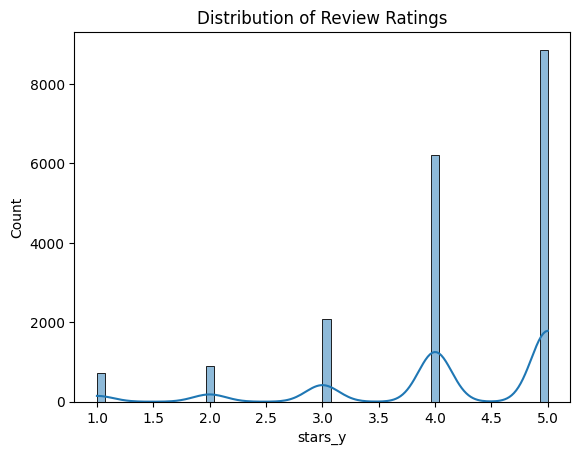

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(refined_dataset['stars_y'], kde=True)
plt.title('Distribution of Review Ratings')
plt.show()


In [64]:
# Add back the 'date' column if it's missing
if 'date' not in refined_dataset.columns:
    # Load the original dataset to get the 'date' column
    attraction_filtered_review_df = pd.read_csv('/content/drive/MyDrive/attraction_filtered_reviews.csv')

    # Merge the 'date' column back into the refined dataset using 'text' as the key
    refined_dataset = refined_dataset.merge(
        attraction_filtered_review_df[['text', 'date']],
        on='text',
        how='inner'
    )

# Ensure 'date' is in datetime format
refined_dataset['date'] = pd.to_datetime(refined_dataset['date'])

# Define the timeframe for filtering
start_date = '2008-01-01'
end_date = '2021-12-31'

# Filter the dataset for the desired timeframe
filtered_dataset = refined_dataset[
    (refined_dataset['date'] >= start_date) &
    (refined_dataset['date'] <= end_date)
]

print(f"Dataset filtered for reviews between {start_date} and {end_date}.")
print(f"Number of reviews in the filtered dataset: {len(filtered_dataset)}")


Dataset filtered for reviews between 2008-01-01 and 2021-12-31.
Number of reviews in the filtered dataset: 18792


In [65]:
print(filtered_dataset.columns)

Index(['text', 'stars_y', 'review_count', 'useful', 'funny', 'date'], dtype='object')


In [66]:
#########.     BERT Sentiment Analysis.     ##########


from transformers import pipeline

# Initialize BERT sentiment-analysis pipeline
try:
    sentiment_pipeline_bert = pipeline(
        'sentiment-analysis',
        model='distilbert-base-uncased-finetuned-sst-2-english',
        device=0  # Use GPU if available
    )
except ValueError:
    print("GPU not available. Switching to CPU.")
    sentiment_pipeline_bert = pipeline(
        'sentiment-analysis',
        model='distilbert-base-uncased-finetuned-sst-2-english',
        device=-1  # Use CPU
    )

# Function to truncate text for BERT
def truncate_text(text, max_length=512):
    return text[:max_length]

# Avoid modifying the original dataset directly
filtered_dataset = filtered_dataset.copy()

# Apply text truncation for BERT
filtered_dataset['text_truncated'] = filtered_dataset['text'].apply(truncate_text)

# Apply BERT sentiment analysis without the 'clean_up_tokenization_spaces' parameter
filtered_dataset['bert_sentiment'] = filtered_dataset['text_truncated'].apply(
    lambda x: sentiment_pipeline_bert(x)[0]['label']
)

print("BERT sentiment analysis complete.")
display(filtered_dataset[['text', 'bert_sentiment']].head())


BERT sentiment analysis complete.


,text,bert_sentiment
0,Came here to print off some documents and was ...,POSITIVE
1,Naked Cyber & Expresso Bar is a 24 hours cyber...,NEGATIVE
2,I visited Naked for the first time this weeken...,NEGATIVE
3,Neat cafe! Delicious sandwiches and sweets wit...,POSITIVE
4,"Naked is a cyber-cafe, one of the first ones t...",POSITIVE


In [67]:
print(filtered_dataset.columns)


Index(['text', 'stars_y', 'review_count', 'useful', 'funny', 'date',
       'text_truncated', 'bert_sentiment'],
      dtype='object')


<ipython-input-68-b34f583cb262>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['cuisine'] = positive_reviews['text'].apply(classify_cuisine)
<ipython-input-68-b34f583cb262>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')


Cuisine Popularity Near Tourist Attractions:
cuisine
other         7224
american       959
vegan          883
italian        817
pizzeria       745
indian         684
japanese       577
mexican        567
ethiopian      472
vietnamese     446
chinese        378
french         342
seafood        335
asian          199
korean         131
thai           119
spanish        107
cajun           91
greek           62
lebanese        45
halal           39
turkish         38
persian         27
brazilian       19
kosher           2
Name: count, dtype: int64


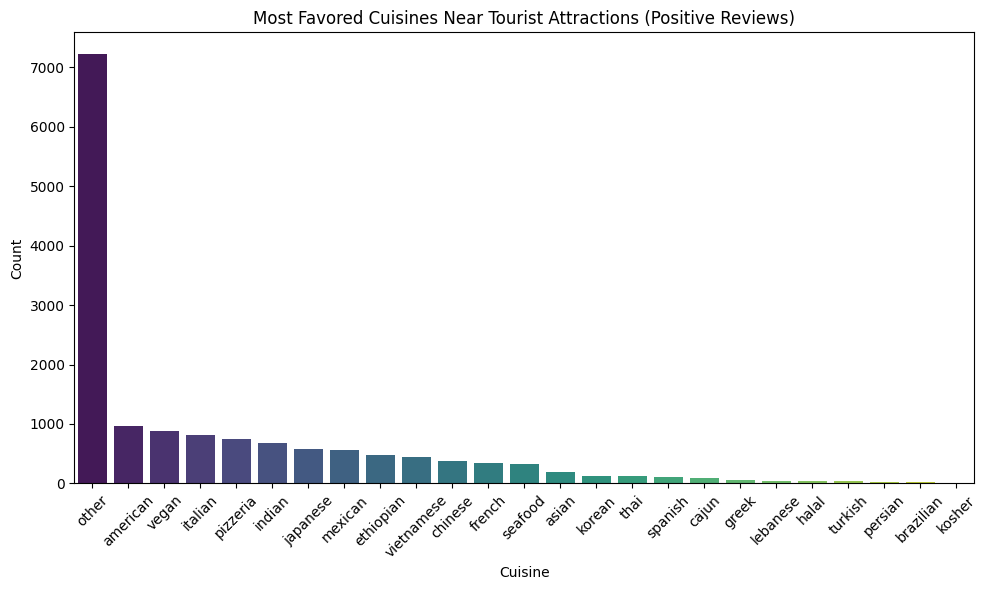

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define cuisine categories and keywords
cuisine_keywords = {
    'halal': ['halal', 'middle eastern', 'arabic'],
    'indian': ['indian', 'curry', 'tandoori', 'biryani'],
    'mexican': ['mexican', 'taco', 'burrito', 'quesadilla'],
    'vegan': ['vegan', 'vegetarian', 'plant-based', 'no meat'],
    'persian': ['persian', 'kebab', 'ghormeh sabzi'],
    'pizzeria': ['pizza', 'pizzeria', 'calzone'],
    'italian': ['italian', 'pasta', 'lasagna', 'risotto'],
    'japanese': ['japanese', 'sushi', 'ramen', 'tempura'],
    'chinese': ['chinese', 'noodles', 'dim sum', 'wontons'],
    'thai': ['thai', 'pad thai', 'curry', 'tom yum'],
    'french': ['french', 'crepes', 'bistro', 'ratatouille'],
    'korean': ['korean', 'kimchi', 'bulgogi'],
    'greek': ['greek', 'gyros', 'moussaka'],
    'cajun': ['cajun', 'creole', 'gumbo'],
    'turkish': ['turkish', 'kebab', 'baklava'],
    'kosher': ['kosher', 'koshert', 'matzo', 'challah'],
    'seafood': ['seafood', 'lobster', 'shrimp', 'oyster'],
    'lebanese': ['lebanese', 'hummus', 'falafel', 'tabbouleh'],
    'spanish': ['spanish', 'paella', 'tapas'],
    'vietnamese': ['vietnamese', 'pho', 'banh mi'],
    'brazilian': ['brazilian', 'churrasco', 'feijoada'],
    'ethiopian': ['ethiopian', 'injera', 'wat'],
    'american': ['american', 'burger', 'steak', 'bbq', 'fried chicken', 'hot dog'],
    'japanese': ['japanese', 'sushi', 'ramen', 'tempura', 'sashimi', 'teriyaki'],
    'italian': ['italian', 'pasta', 'lasagna', 'risotto', 'spaghetti', 'bruschetta'],
    'indian': ['indian', 'curry', 'tandoori', 'biryani', 'naan', 'masala'],
    'asian': ['bubble tea', 'boba', 'green tea', 'matcha'],


    'other': ['restaurant','dine']  # Catch-all category
}

# Function to classify cuisines based on keywords
def classify_cuisine(text):
    text_lower = str(text).lower()
    for cuisine, keywords in cuisine_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            return cuisine
    return 'other'

# Load the dataset
file_path = '/content/drive/MyDrive/refined_dataset.csv'
dataset = pd.read_csv(file_path)

# Filter dataset for positive reviews
positive_reviews = filtered_dataset[filtered_dataset['bert_sentiment'] == 'POSITIVE']


# Apply cuisine classification
positive_reviews['cuisine'] = positive_reviews['text'].apply(classify_cuisine)

# Count the frequency of each cuisine
cuisine_counts = positive_reviews['cuisine'].value_counts()

# Display results
print("Cuisine Popularity Near Tourist Attractions:")
print(cuisine_counts)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')
plt.title('Most Favored Cuisines Near Tourist Attractions (Positive Reviews)')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [69]:
print(positive_reviews[positive_reviews['cuisine'] == 'other']['text'].head(20))


0     Came here to print off some documents and was ...
3     Neat cafe! Delicious sandwiches and sweets wit...
7     When searching for open mic night in Edmonton,...
9     So I recently got to visit this place. It's a ...
10    Cool space! They have computers and a stage an...
12    Great place for all not just the techies  we l...
14    I didnt know this place was just beside of the...
17    I love Breadland - it's one of those places wh...
18    Love the bread from here.  They have a nice va...
19    This is not your supermarket type bread store....
20    Having only visited this location once, I have...
22    Yum! Fresh! Really enjoy. Local is a plus. Doe...
23    This is the best bread bakery! They have so ma...
24    This bakery is new to Oliver Square area, and ...
25    I love me some pastries and bread. All organic...
26    I like their bread and their offerings of spel...
28    A couple weeks ago I noticed this little baker...
29    Amazing sourdough baked goods made with or

In [70]:
#####.  VADER Sentiment Analysis #######

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
filtered_dataset['vader_compound'] = filtered_dataset['text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else None
)

# Convert VADER compound scores to sentiment labels
filtered_dataset['vader_sentiment'] = filtered_dataset['vader_compound'].apply(
    lambda x: 'POSITIVE' if x >= 0.05 else ('NEGATIVE' if x <= -0.05 else 'NEUTRAL') if x is not None else None
)

print("VADER sentiment analysis complete.")
display(filtered_dataset[['text', 'vader_compound', 'vader_sentiment']].tail())





VADER sentiment analysis complete.


,text,vader_compound,vader_sentiment
18837,When it comes to Ramen in Edmonton. This is y...,0.9925,POSITIVE
18839,Great Ramen.\nService was asking me to take my...,0.7645,POSITIVE
18840,"Great flavour to the Ramen dishes, and the ser...",0.8750,POSITIVE
18841,My husband and I do an instagram date on weeke...,0.9615,POSITIVE
18842,This place is impressively focused. They don't...,0.8038,POSITIVE


In [71]:
from textblob import TextBlob

# Apply TextBlob sentiment analysis
filtered_dataset['textblob_polarity'] = filtered_dataset['text'].apply(
    lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None
)

# Convert TextBlob polarity scores to sentiment labels
filtered_dataset['textblob_sentiment'] = filtered_dataset['textblob_polarity'].apply(
    lambda x: 'POSITIVE' if x > 0 else ('NEGATIVE' if x < 0 else 'NEUTRAL') if x is not None else None
)

print("TextBlob sentiment analysis complete.")
display(filtered_dataset[['text', 'textblob_polarity', 'textblob_sentiment']].tail())


TextBlob sentiment analysis complete.


,text,textblob_polarity,textblob_sentiment
18837,When it comes to Ramen in Edmonton. This is y...,0.233062,POSITIVE
18839,Great Ramen.\nService was asking me to take my...,0.045833,POSITIVE
18840,"Great flavour to the Ramen dishes, and the ser...",0.238889,POSITIVE
18841,My husband and I do an instagram date on weeke...,0.360714,POSITIVE
18842,This place is impressively focused. They don't...,0.111883,POSITIVE


In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Define True Sentiment Labels (Ground Truth) Based on 'stars_y'
def determine_sentiment(stars):
    if stars >= 4:
        return 'POSITIVE'
    elif stars <= 2:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

# Add the true sentiment labels to the dataset
filtered_dataset['true_sentiment'] = filtered_dataset['stars_y'].apply(determine_sentiment)
y_true = filtered_dataset['true_sentiment'].values

# Step 2: Fetch Predictions from Models
textblob_pred = filtered_dataset['textblob_sentiment'].values
vader_pred = filtered_dataset['vader_sentiment'].values
bert_pred = filtered_dataset['bert_sentiment'].values

# Step 3: Evaluation Metrics for Each Model
# TextBlob Metrics
print("TextBlob Metrics:")
print(classification_report(y_true, textblob_pred))
print(confusion_matrix(y_true, textblob_pred))

# VADER Metrics
print("\nVADER Metrics:")
print(classification_report(y_true, vader_pred))
print(confusion_matrix(y_true, vader_pred))

# BERT Metrics
print("\nBERT Metrics:")
print(classification_report(y_true, bert_pred))
print(confusion_matrix(y_true, bert_pred))

# Step 4: Accuracy Comparison Across Models
models = ['TextBlob', 'VADER', 'BERT']
accuracies = [
    accuracy_score(y_true, textblob_pred),
    accuracy_score(y_true, vader_pred),
    accuracy_score(y_true, bert_pred)
]

print("\nAccuracy Comparison:")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.2f}")

# Step 5: Error Analysis with Random Sampling
# Create DataFrame for error analysis
error_analysis_df = filtered_dataset[['text', 'true_sentiment']].copy()
error_analysis_df['bert_sentiment'] = bert_pred
error_analysis_df['vader_sentiment'] = vader_pred
error_analysis_df['textblob_sentiment'] = textblob_pred

# Identify cases
correctly_classified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] == error_analysis_df['bert_sentiment']) &
    ((error_analysis_df['true_sentiment'] != error_analysis_df['vader_sentiment']) |
     (error_analysis_df['true_sentiment'] != error_analysis_df['textblob_sentiment']))
]

misclassified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] != error_analysis_df['bert_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['vader_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['textblob_sentiment'])
]

# Sample random examples
sample_size = 5  # Adjust sample size as needed
sample_correct_by_bert = correctly_classified_by_bert.sample(n=min(sample_size, len(correctly_classified_by_bert)), random_state=42)
sample_misclassified_by_bert = misclassified_by_bert.sample(n=min(sample_size, len(misclassified_by_bert)), random_state=42)

# Display samples
print("\nSampled Reviews Correctly Classified by BERT but Misclassified by Others:")
sample_correct_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]

print("\nSampled Reviews Misclassified by BERT but Correctly Classified by Others:")
sample_misclassified_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]


TextBlob Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.60      0.36      0.45      1639
     NEUTRAL       0.03      0.00      0.00      2075
    POSITIVE       0.83      0.98      0.90     15078

    accuracy                           0.82     18792
   macro avg       0.49      0.45      0.45     18792
weighted avg       0.73      0.82      0.76     18792

[[  597    14  1028]
 [  166     2  1907]
 [  232    47 14799]]

VADER Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.62      0.38      0.47      1639
     NEUTRAL       0.16      0.01      0.02      2075
    POSITIVE       0.84      0.98      0.91     15078

    accuracy                           0.82     18792
   macro avg       0.54      0.46      0.47     18792
weighted avg       0.75      0.82      0.77     18792

[[  625    49   965]
 [  194    24  1857]
 [  182    81 14815]]

BERT Metrics:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    NEGATIVE       0.40      0.85      0.55      1639
     NEUTRAL       0.00      0.00      0.00      2075
    POSITIVE       0.91      0.92      0.92     15078

    accuracy                           0.82     18792
   macro avg       0.44      0.59      0.49     18792
weighted avg       0.77      0.82      0.78     18792

[[ 1400     0   239]
 [  933     0  1142]
 [ 1151     0 13927]]

Accuracy Comparison:
TextBlob: 0.82
VADER: 0.82
BERT: 0.82

Sampled Reviews Correctly Classified by BERT but Misclassified by Others:

Sampled Reviews Misclassified by BERT but Correctly Classified by Others:


,text,true_sentiment,bert_sentiment,vader_sentiment,textblob_sentiment
11772,It probably seems like I say this every other ...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
11800,"My first experience at RGE RD, two weeks after...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
18065,The meat here is excellent. Big fan of the smo...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
11498,Nice place to go for lunch. They take reservat...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
6936,The baking is good. It is because of the terr...,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE


In [73]:
# Step 3: Evaluation Metrics for Each Model
# TextBlob Metrics
print("TextBlob Metrics:")
print(classification_report(y_true, textblob_pred))
print(confusion_matrix(y_true, textblob_pred))


TextBlob Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.60      0.36      0.45      1639
     NEUTRAL       0.03      0.00      0.00      2075
    POSITIVE       0.83      0.98      0.90     15078

    accuracy                           0.82     18792
   macro avg       0.49      0.45      0.45     18792
weighted avg       0.73      0.82      0.76     18792

[[  597    14  1028]
 [  166     2  1907]
 [  232    47 14799]]


In [74]:
# VADER Metrics
print("\nVADER Metrics:")
print(classification_report(y_true, vader_pred))
print(confusion_matrix(y_true, vader_pred))



VADER Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.62      0.38      0.47      1639
     NEUTRAL       0.16      0.01      0.02      2075
    POSITIVE       0.84      0.98      0.91     15078

    accuracy                           0.82     18792
   macro avg       0.54      0.46      0.47     18792
weighted avg       0.75      0.82      0.77     18792

[[  625    49   965]
 [  194    24  1857]
 [  182    81 14815]]


In [75]:

# BERT Metrics
print("\nBERT Metrics:")
print(classification_report(y_true, bert_pred))
print(confusion_matrix(y_true, bert_pred))


BERT Metrics:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    NEGATIVE       0.40      0.85      0.55      1639
     NEUTRAL       0.00      0.00      0.00      2075
    POSITIVE       0.91      0.92      0.92     15078

    accuracy                           0.82     18792
   macro avg       0.44      0.59      0.49     18792
weighted avg       0.77      0.82      0.78     18792

[[ 1400     0   239]
 [  933     0  1142]
 [ 1151     0 13927]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
# Step 4: Accuracy Comparison Across Models
models = ['TextBlob', 'VADER', 'BERT']
accuracies = [
    accuracy_score(y_true, textblob_pred),
    accuracy_score(y_true, vader_pred),
    accuracy_score(y_true, bert_pred)
]

print("\nAccuracy Comparison:")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.2f}")



Accuracy Comparison:
TextBlob: 0.82
VADER: 0.82
BERT: 0.82


In [77]:
# Step 5: Error Analysis with Random Sampling
# Create DataFrame for error analysis
error_analysis_df = filtered_dataset[['text', 'true_sentiment']].copy()
error_analysis_df['bert_sentiment'] = bert_pred
error_analysis_df['vader_sentiment'] = vader_pred
error_analysis_df['textblob_sentiment'] = textblob_pred

# Identify cases
correctly_classified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] == error_analysis_df['bert_sentiment']) &
    ((error_analysis_df['true_sentiment'] != error_analysis_df['vader_sentiment']) |
     (error_analysis_df['true_sentiment'] != error_analysis_df['textblob_sentiment']))
]

misclassified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] != error_analysis_df['bert_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['vader_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['textblob_sentiment'])
]

# Sample random examples
sample_size = 5  # Adjust sample size as needed
sample_correct_by_bert = correctly_classified_by_bert.sample(n=min(sample_size, len(correctly_classified_by_bert)), random_state=42)
sample_misclassified_by_bert = misclassified_by_bert.sample(n=min(sample_size, len(misclassified_by_bert)), random_state=42)

# Display samples
print("\nSampled Reviews Correctly Classified by BERT but Misclassified by Others:")
sample_correct_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]

print("\nSampled Reviews Misclassified by BERT but Correctly Classified by Others:")
sample_misclassified_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]



Sampled Reviews Correctly Classified by BERT but Misclassified by Others:

Sampled Reviews Misclassified by BERT but Correctly Classified by Others:


,text,true_sentiment,bert_sentiment,vader_sentiment,textblob_sentiment
11772,It probably seems like I say this every other ...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
11800,"My first experience at RGE RD, two weeks after...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
18065,The meat here is excellent. Big fan of the smo...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
11498,Nice place to go for lunch. They take reservat...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
6936,The baking is good. It is because of the terr...,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE


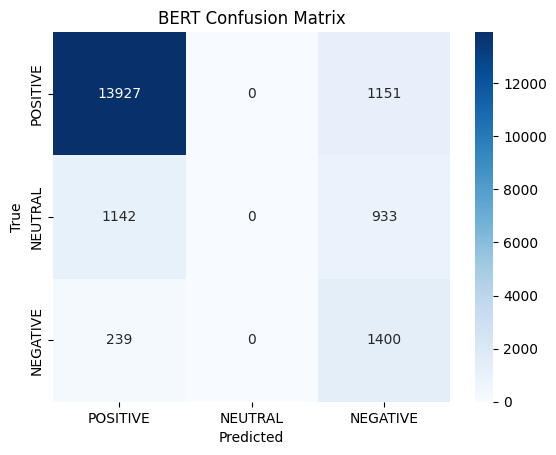

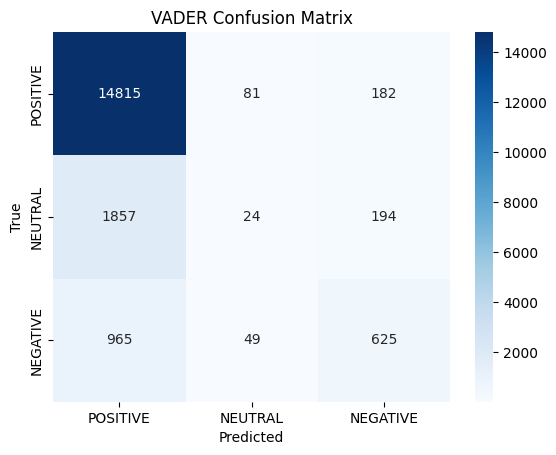

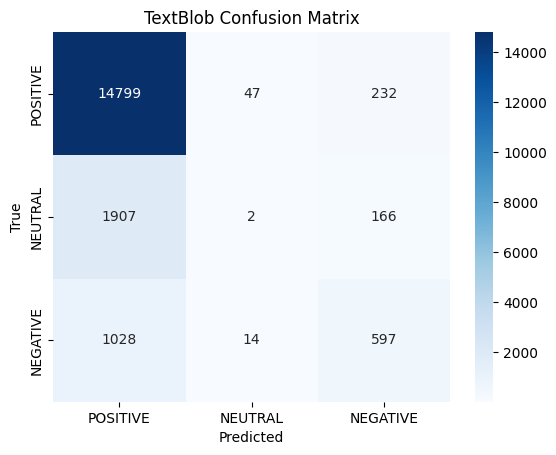

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_true, bert_pred, "BERT Confusion Matrix")
plot_confusion_matrix(y_true, vader_pred, "VADER Confusion Matrix")
plot_confusion_matrix(y_true, textblob_pred, "TextBlob Confusion Matrix")


In [79]:
import pandas as pd

# Step 1: Convert Review Dates to Year
# Ensure the 'date' column is in datetime format
filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'])
filtered_dataset['year'] = filtered_dataset['date'].dt.year

# Step 2: Aggregate Sentiment Scores by Year
# Replace 'vader_compound' with the sentiment score column you want to analyze
filtered_dataset['sentiment_score'] = filtered_dataset['vader_compound']
yearly_sentiments = filtered_dataset.groupby('year')['sentiment_score'].mean()

# Step 3: Define External Events
external_events = {
    2010: "Economic Downturn",
    2013: "Tourist Spike (Local Event)",
    2020: "COVID-19 Pandemic",
}

# Step 4: Add Events to the Aggregated Sentiment Data
# Reset index to convert the series into a DataFrame
yearly_sentiments_df = yearly_sentiments.reset_index()

# Map external events to the year column
yearly_sentiments_df['event'] = yearly_sentiments_df['year'].map(external_events).fillna("")

# Step 5: Display the Resulting DataFrame
yearly_sentiments_df


,year,sentiment_score,event
0,2008,0.900133,
1,2009,0.889375,
2,2010,0.832813,Economic Downturn
3,2011,0.838060,
4,2012,0.828190,
5,2013,0.842449,Tourist Spike (Local Event)
6,2014,0.837658,
7,2015,0.818846,
8,2016,0.799313,
9,2017,0.805248,


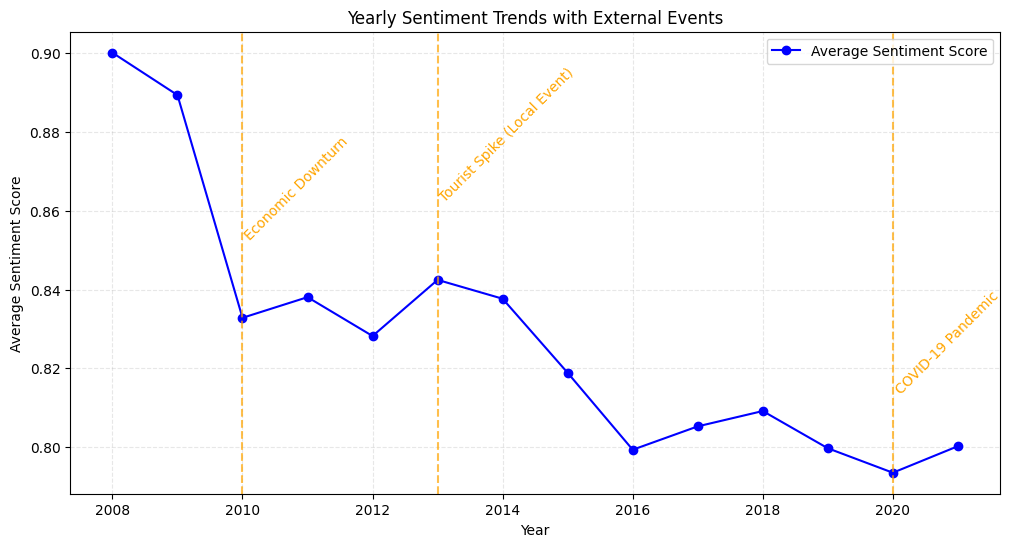

In [80]:
import matplotlib.pyplot as plt

# Plot sentiment trends
plt.figure(figsize=(12, 6))
plt.plot(yearly_sentiments_df['year'], yearly_sentiments_df['sentiment_score'], marker='o', label='Average Sentiment Score', color='blue')

# Annotate external events
for index, row in yearly_sentiments_df.iterrows():
    if row['event']:  # Only annotate years with events
        plt.axvline(x=row['year'], color='orange', linestyle='--', alpha=0.7)
        plt.text(row['year'], row['sentiment_score'] + 0.02, row['event'], rotation=45, color='orange', fontsize=10)

# Enhance plot appearance
plt.title("Yearly Sentiment Trends with External Events")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.show()



In [81]:
# Set 'year' as the index and ensure it's in datetime format for ARIMA
yearly_sentiments_df['year'] = pd.to_datetime(yearly_sentiments_df['year'], format='%Y')
sentiment_trend = yearly_sentiments_df.set_index('year')['sentiment_score']


In [82]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define and fit ARIMA model
arima_model = ARIMA(sentiment_trend, order=(1, 1, 1))  # Adjust (p, d, q) parameters as needed
arima_result = arima_model.fit()

# Forecast for the next 5 years
forecast_arima = arima_result.get_forecast(steps=5)
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

# Calculate error metrics
mae = mean_absolute_error(sentiment_trend, arima_result.fittedvalues)
mse = mean_squared_error(sentiment_trend, arima_result.fittedvalues)
print(f"ARIMA Performance:\nMAE: {mae:.4f}\nMSE: {mse:.4f}")


ARIMA Performance:
MAE: 0.0770
MSE: 0.0582


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

<ipython-input-83-cf13ee4c9698>:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_years = pd.date_range(start=sentiment_trend.index[-1], periods=6, freq='Y')[1:]


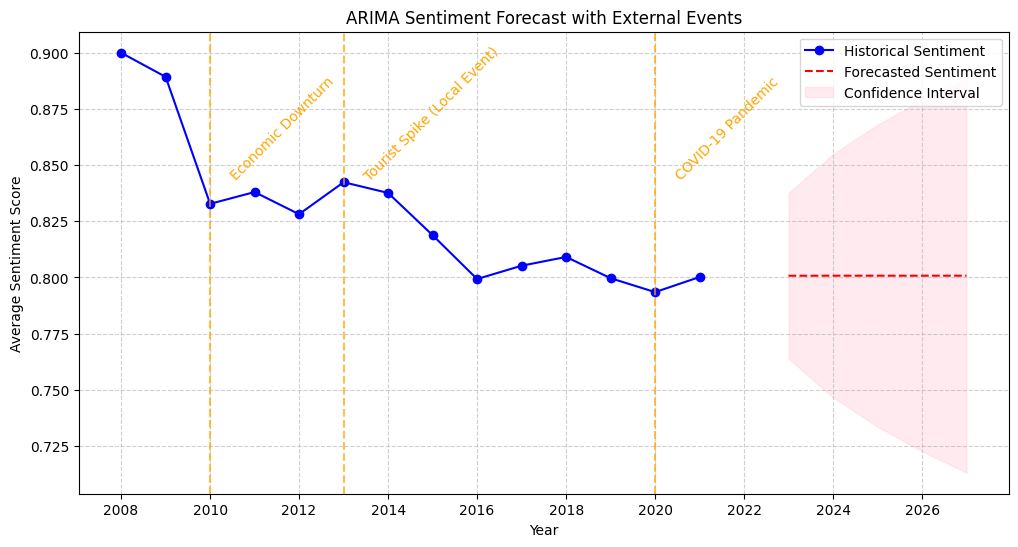

In [83]:
# Plot historical data and forecast
plt.figure(figsize=(12, 6))

# Historical sentiment trend
plt.plot(sentiment_trend, label='Historical Sentiment', marker='o', color='blue')

# Forecasted sentiment
forecast_years = pd.date_range(start=sentiment_trend.index[-1], periods=6, freq='Y')[1:]
plt.plot(forecast_years, forecast_mean, label='Forecasted Sentiment', linestyle='--', color='red')

# Confidence intervals
plt.fill_between(forecast_years, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Annotate external events
for year, event in external_events.items():
    plt.axvline(x=pd.Timestamp(year=year, month=1, day=1), color='orange', linestyle='--', alpha=0.7)
    plt.text(pd.Timestamp(year=year, month=6, day=1), sentiment_trend.min() + 0.05, event, rotation=45, color='orange', fontsize=10)

# Enhance plot appearance
plt.title("ARIMA Sentiment Forecast with External Events")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.grid(alpha=0.6, linestyle='--')
plt.show()


In [84]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Perform the Augmented Dickey-Fuller (ADF) test for stationarity
adf_test = adfuller(sentiment_trend)

# ADF test results
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"\t{key}: {value:.4f}")

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary. Consider differencing.")


ADF Statistic: -8.9515
p-value: 0.0000
Critical Values:
	1%: -4.6652
	5%: -3.3672
	10%: -2.8030
The data is stationary.


In [85]:
from pmdarima import auto_arima

# Automatically identify the best ARIMA parameters
auto_model = auto_arima(sentiment_trend, seasonal=False, trace=True, suppress_warnings=True)

print(f"Best ARIMA order: {auto_model.order}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58.760, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.703, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.841, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.886, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.342, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.556 seconds
Best ARIMA order: (0, 1, 0)


Performing stepwise search to minimize aic


<ipython-input-86-1bcc1572ad4a>:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sentiment_trend.index = pd.date_range(start=str(sentiment_trend.index[0]), periods=len(sentiment_trend), freq='Y')


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58.760, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.841, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.886, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.342, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.493 seconds
Best ARIMA Order: (0, 1, 0)
ARIMA Performance:
MAE: 0.0766
MSE: 0.0582
RMSE: 0.2413


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


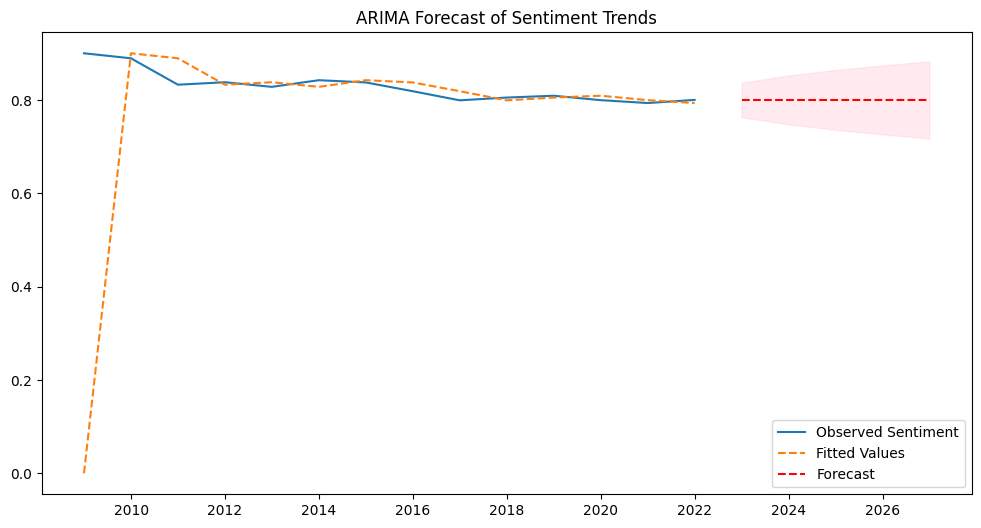

In [86]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'filtered_dataset' is already loaded and available

# Ensure the 'date' column is in datetime format and sort by date
filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'])
filtered_dataset.sort_values('date', inplace=True)

# Aggregate the sentiment scores by year (or other desired frequency)
# Adjust 'vader_compound' to your sentiment score column
sentiment_trend = filtered_dataset.groupby(filtered_dataset['date'].dt.year)['vader_compound'].mean()

# Ensure it's a time-series object
sentiment_trend.index = pd.date_range(start=str(sentiment_trend.index[0]), periods=len(sentiment_trend), freq='Y')

# Auto-ARIMA to find the best parameters
auto_model = auto_arima(sentiment_trend, seasonal=False, trace=True, suppress_warnings=True)
best_order = auto_model.order
print(f"Best ARIMA Order: {best_order}")

# Fit ARIMA model with the identified order
arima_model = ARIMA(sentiment_trend, order=best_order)
arima_result = arima_model.fit()

# Forecast for 5 future periods
forecast_arima = arima_result.get_forecast(steps=5)
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

# Calculate metrics
mae = mean_absolute_error(sentiment_trend, arima_result.fittedvalues)
mse = mean_squared_error(sentiment_trend, arima_result.fittedvalues)
rmse = np.sqrt(mse)

# Print performance
print(f"ARIMA Performance:\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend, label='Observed Sentiment')
plt.plot(arima_result.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(forecast_mean, label='Forecast', linestyle='--', color='red')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast of Sentiment Trends')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


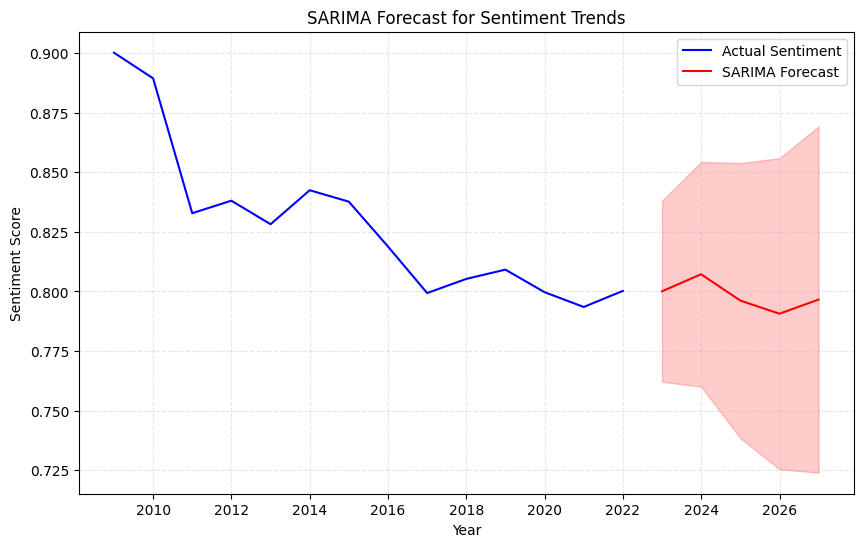

SARIMA Predictions:
2022-12-31    0.800053
2023-12-31    0.807194
2024-12-31    0.796157
2025-12-31    0.790647
2026-12-31    0.796581
Freq: YE-DEC, Name: predicted_mean, dtype: float64
SARIMA Performance Metrics:
MAE: 0.11008108738013346
MSE: 0.07190066951509579
RMSE: 0.26814300198792396


In [87]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define SARIMA model with 5-year seasonal periodicity
seasonal_order = (1, 1, 1, 5)  # Seasonal order (P, D, Q, s) with s=5 for long-term cycles
sarima_model = SARIMAX(sentiment_trend, order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the next 5 years
sarima_forecast = sarima_result.get_forecast(steps=5)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Plot SARIMA results
plt.figure(figsize=(10, 6))
plt.plot(sentiment_trend, label='Actual Sentiment', color='blue')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMA Forecast for Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# Print SARIMA predictions
print("SARIMA Predictions:")
print(sarima_pred)

# Evaluate SARIMA performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

sarima_mae = mean_absolute_error(sentiment_trend, sarima_result.fittedvalues)
sarima_mse = mean_squared_error(sentiment_trend, sarima_result.fittedvalues)
sarima_rmse = np.sqrt(sarima_mse)

print(f"SARIMA Performance Metrics:\nMAE: {sarima_mae}\nMSE: {sarima_mse}\nRMSE: {sarima_rmse}")



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsjp8gybm/bkb4h051.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsjp8gybm/vkewkmxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75152', 'data', 'file=/tmp/tmpsjp8gybm/bkb4h051.json', 'init=/tmp/tmpsjp8gybm/vkewkmxv.json', 'output', 'file=/tmp/tmpsjp8gybm/prophet_modelpkmgc8x0/prophet_model-20241118081338.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:13:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:

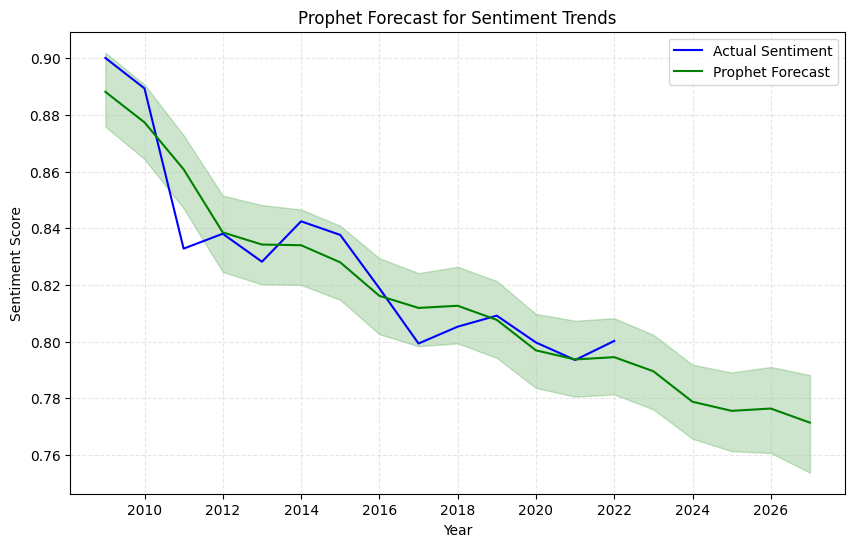

Prophet Predictions:
           ds      yhat  yhat_lower  yhat_upper
14 2022-12-31  0.789515    0.776030    0.802381
15 2023-12-31  0.778751    0.765680    0.791852
16 2024-12-31  0.775530    0.761292    0.789057
17 2025-12-31  0.776347    0.760663    0.791035
18 2026-12-31  0.771370    0.753687    0.788142
Prophet Performance Metrics:
MAE: 0.007818620254979178
MSE: 0.00010966694059764874
RMSE: 0.010472198460574013


In [88]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the data for Prophet
prophet_data = sentiment_trend.reset_index().rename(columns={'index': 'ds', 'vader_compound': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create a dataframe for future predictions
future = prophet_model.make_future_dataframe(periods=5, freq='Y')
prophet_forecast = prophet_model.predict(future)

# Extract predictions and intervals
prophet_pred = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot Prophet results
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual Sentiment', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(prophet_forecast['ds'],
                 prophet_forecast['yhat_lower'],
                 prophet_forecast['yhat_upper'],
                 color='green', alpha=0.2)
plt.title('Prophet Forecast for Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# Print Prophet predictions
print("Prophet Predictions:")
print(prophet_pred.tail())

# Evaluate Prophet performance
prophet_mae = mean_absolute_error(prophet_data['y'], prophet_forecast['yhat'][:len(prophet_data)])
prophet_mse = mean_squared_error(prophet_data['y'], prophet_forecast['yhat'][:len(prophet_data)])
prophet_rmse = np.sqrt(prophet_mse)

print(f"Prophet Performance Metrics:\nMAE: {prophet_mae}\nMSE: {prophet_mse}\nRMSE: {prophet_rmse}")
